In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = most_recent_date[0]
most_recent_date

'2017-08-23'

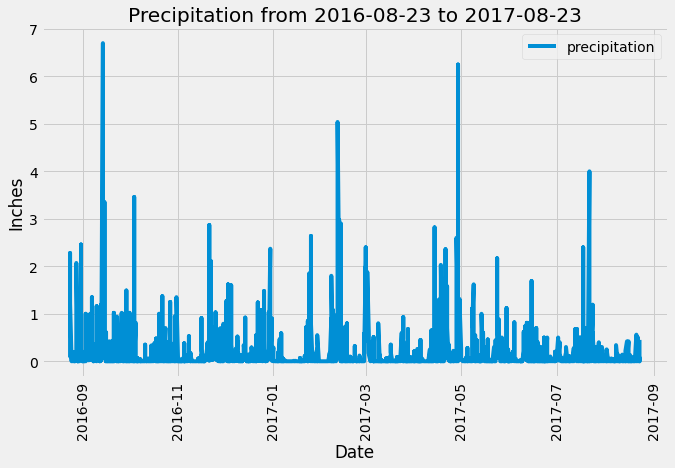

In [23]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database. 

# 1. Calculate the date one year from the last date in data set.
year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days = 365)

# 2. Perform a query to retrieve the data and precipitation scores
date_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()

# 3. Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(date_prcp, columns = ['date', 'precipitation'])
prcp_df['date'] = pd.to_datetime(prcp_df['date'], format = '%Y-%m-%d')
prcp_df['date'] = prcp_df['date'].dt.date
prcp_df.set_index('date', inplace = True)

# 4. Sort the dataframe by date
prcp_df = prcp_df.sort_values(by = 'date', ascending = True)
prcp_df = prcp_df.dropna()

# 5. Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_df.plot(figsize=(10,6))
ax.set_title(f'Precipitation from {year_ago.date()} to {most_recent_date}')
ax.set_xlabel('Date')
ax.set_ylabel('Inches')

plt.xticks(rotation=90)
plt.show()

In [25]:
# Use Pandas to calcualte the summary statistics for the precipitation data
stats = prcp_df.describe()
stats

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [26]:
# Design a query to calculate the total number stations in the dataset
num_stations = session.query(func.count(Station.station)).all()
num_stations

[(9)]

In [27]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
stations_count = (session.query(Measurement.station, func.count(Measurement.station)).
                  group_by(Measurement.station).
                  order_by(func.count(Measurement.station).desc()).all())
stations_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [28]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = stations_count[0][0]

sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
                
session.query(*sel).filter(Measurement.station == most_active_station).all()

[(54.0, 85.0, 71.66378066378067)]

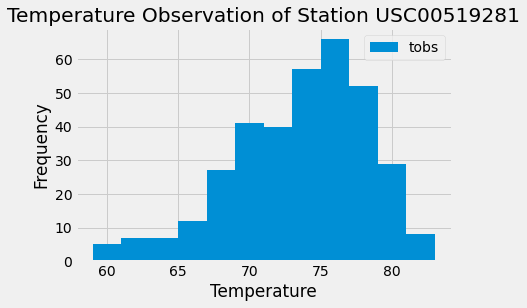

In [29]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_st_last12mo = (session.query(Measurement.tobs).
             filter(Measurement.station == most_active_station).
             filter(Measurement.date >= year_ago).
             order_by(Measurement.date.desc()).all())

# Get the list of temperatures for the last 12 months
result = []
for index in range(len(most_active_st_last12mo)):
    result.append(most_active_st_last12mo[index][0])

# Plot histogram 
plt.hist(result, bins=12)
plt.title(f'Temperature Observation of Station {most_active_station}')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.show()

# Close session

In [30]:
# Close Session
session.close()